In [10]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [3]:
import scanpy as sc
import numpy as np 
from matplotlib import pyplot as plt
import yaml

# Data Loading

In [4]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset3/"

In [5]:
adata_sc = sc.read(data_path + "scRNA_data.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 31299 × 19980
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells_expressed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'sparsity'

In [6]:
adata_st = sc.read(data_path + "spatial_data.h5ad")
adata_st

AnnData object with n_obs × n_vars = 5967 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells_expressed'
    uns: 'gearyC', 'log1p', 'moranI', 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Config

In [7]:
# Read config yaml
with open("data/Dataset3/train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed

{'cluster_label': None,
 'lambda_count': 1e-06,
 'lambda_ct_islands': 0,
 'lambda_d': 1,
 'lambda_f_reg': 1e-06,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1,
 'lambda_sparsity_g1': 0,
 'learning_rate': 0.1,
 'filter': True,
 'num_epochs': 30,
 'random_state': 42,
 'target_count': None}

# Train/val split

In [8]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.seed(config['random_state'])
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

123 training genes:  ['cplx3' 'galr2' 'avpr1a' 'adora2a' 'oxt' 'rxfp1' 'npy1r' 'ano3' 'kiss1r'
 'sema4d'] ...
31 validation genes:  ['lmod1' 'chat' 'crhr1' 'slc17a8' 'cenpe' 'crhbp' 'sp9' 'col25a1' 'htr2c'
 'esr1'] ...


# Warmup Run

In [9]:
config

{'cluster_label': None,
 'lambda_count': 1e-06,
 'lambda_ct_islands': 0,
 'lambda_d': 1,
 'lambda_f_reg': 1e-06,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1,
 'lambda_sparsity_g1': 0,
 'learning_rate': 0.1,
 'filter': True,
 'num_epochs': 30,
 'random_state': 42,
 'target_count': None}

In [ ]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        experiment_name="warmup_dataset6",
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Preprocessing data...
Using 154 shared marker genes.
Allocating nearest neighbor graphs to dense tensors...
spatial_graph_conn allocated: shape=(5967, 5967), size=135.82 MiB
spatial_graph_dist allocated: shape=(5967, 5967), size=135.82 MiB
Done.
Computing CT OHE...
Done.



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 186 M  | n/a  
---------------------------------------------------------
186 M     Trainable params
0         Non-trainable params
186 M     Total params
747.170   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 31 genes
S matrix shape: torch.Size([31299, 31])
G matrix shape: torch.Size([5967, 31])


Trainig:   0%|          | 0/30 [00:00<?, ?it/s]


Training with 123 genes
S matrix shape: torch.Size([31299, 123])
G matrix shape: torch.Size([5967, 123])


Metric val_score improved. New best score: 0.471
Trainig:  70%|███████   | 21/30 [05:14<02:43, 18.15s/it]

In [12]:
for key, values in ad_map.uns['training_history'].items():
    print(f"{key} initial values: ", values[:4])

total_loss initial values:  [336076512.0, 290952640.0, 250738736.0, 215339568.0]
main_loss initial values:  [0.5019548535346985, 0.5020468235015869, 0.5021457672119141, 0.5022499561309814]
vg_reg initial values:  [0.349263072013855, 0.3492553234100342, 0.3492470681667328, 0.3492380976676941]
kl_reg initial values:  [3.250502049922943e-05, 3.0033872462809086e-05, 2.7323607355356216e-05, 2.462684642523527e-05]
entropy_reg initial values:  [-256474.390625, -258002.3125, -259532.84375, -261030.484375]
l1_term initial values:  [149025312.0, 131838016.0, 116086352.0, 101922888.0]
l2_term initial values:  [186778624.0, 158841200.0, 134378096.0, 113141584.0]
sparsity_term initial values:  []
neighborhood_term initial values:  [0.6758486032485962, 0.6758890748023987, 0.6759330034255981, 0.6759793162345886]
getis_ord_term initial values:  [0.7506843209266663, 0.7507067322731018, 0.7507311701774597, 0.7507570385932922]
moran_term initial values:  [-0.0010183457052335143, -0.001001374563202262, -0

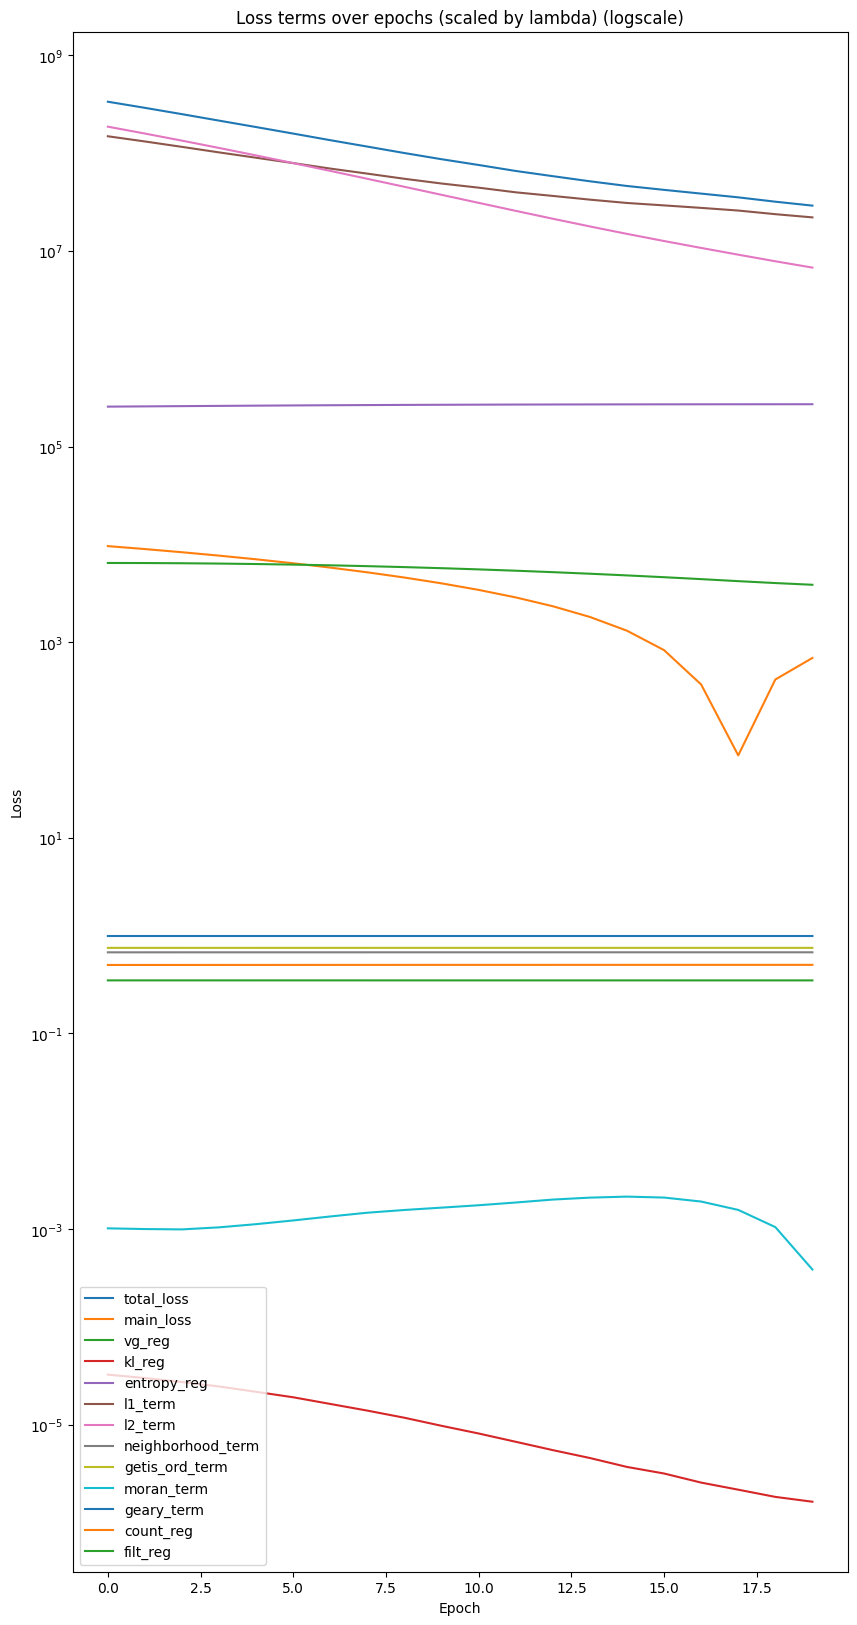

In [13]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=True, lambda_scale=True, show_total_loss=True,)

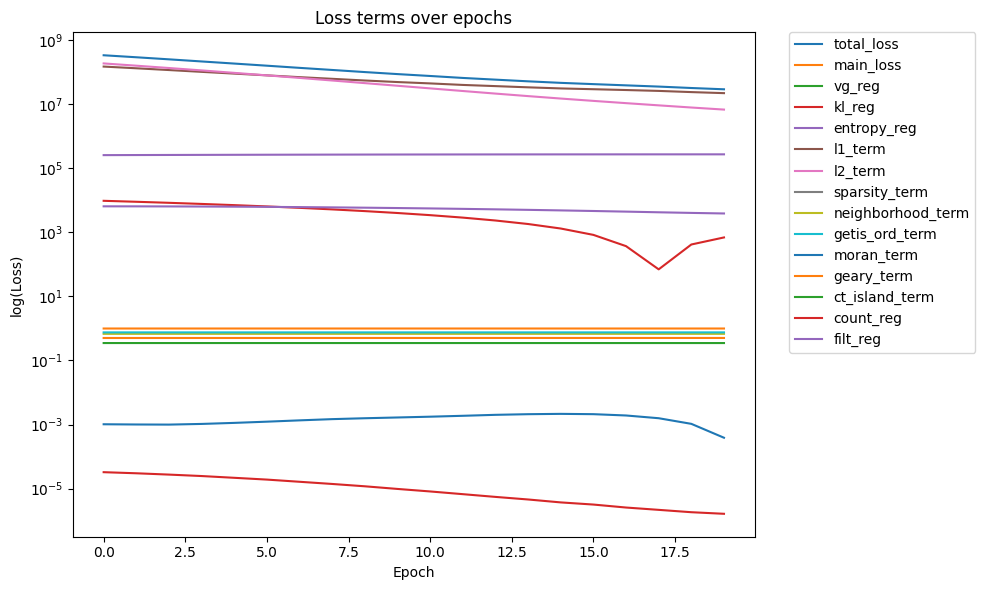

In [ ]:
plt.figure(figsize=(10, 6))
title = 'Loss terms over epochs'

for key, values in ad_map.uns['training_history'].items():
    if values:
        y = np.abs(np.array(values))
        plt.semilogy(y, label=key)

plt.xlabel('Epoch')
plt.ylabel('log(Loss)')
plt.title(title)
plt.legend(
    bbox_to_anchor=(1.05, 1),  # outside on the right
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


# Model training

In [10]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 62.6 M | n/a  
---------------------------------------------------------
62.6 M    Trainable params
0         Non-trainable params
62.6 M    Total params
250.392   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 31 genes
S matrix shape: torch.Size([31299, 31])
G matrix shape: torch.Size([2000, 31])

Validation 0: {'val_score': 0.36837249994277954, 'val_sparsity-weighted_score': 0.012781300581991673, 'val_AUC': 0.378003865480423, 'val_entropy': 0.9343515038490295}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 124 genes
S matrix shape: torch.Size([31299, 124])
G matrix shape: torch.Size([2000, 124])


Trainig:   0%|          | 1/1000 [00:12<3:30:50, 12.66s/it]

Epoch 0: {'loss': -2.9786360263824463, 'main_loss': 0.35334035754203796, 'vg_reg': 0.12005266547203064, 'kl_reg': 2.7438860072948046e-08, 'entropy_reg': -0.00022228280431590974, 'l1_term': 4.994828373128257e-08, 'l2_term': 6.259884277604044e-11, 'sparsity_term': 0.4005194306373596, 'neighborhood_term': 0.516766369342804, 'getis_ord_term': 0.6010982394218445, 'moran_term': -0.0005592363886535168, 'geary_term': 0.9876405000686646}


Trainig:   5%|▌         | 50/1000 [10:01<3:14:16, 12.27s/it]


Validation 49: {'val_score': 0.43507662415504456, 'val_sparsity-weighted_score': 0.015761815011501312, 'val_AUC': 0.542172372341156, 'val_entropy': 0.7390508055686951}


Trainig:  10%|█         | 100/1000 [20:03<3:00:27, 12.03s/it]


Validation 99: {'val_score': 0.4179322123527527, 'val_sparsity-weighted_score': 0.01563902199268341, 'val_AUC': 0.5620603561401367, 'val_entropy': 0.27680402994155884}


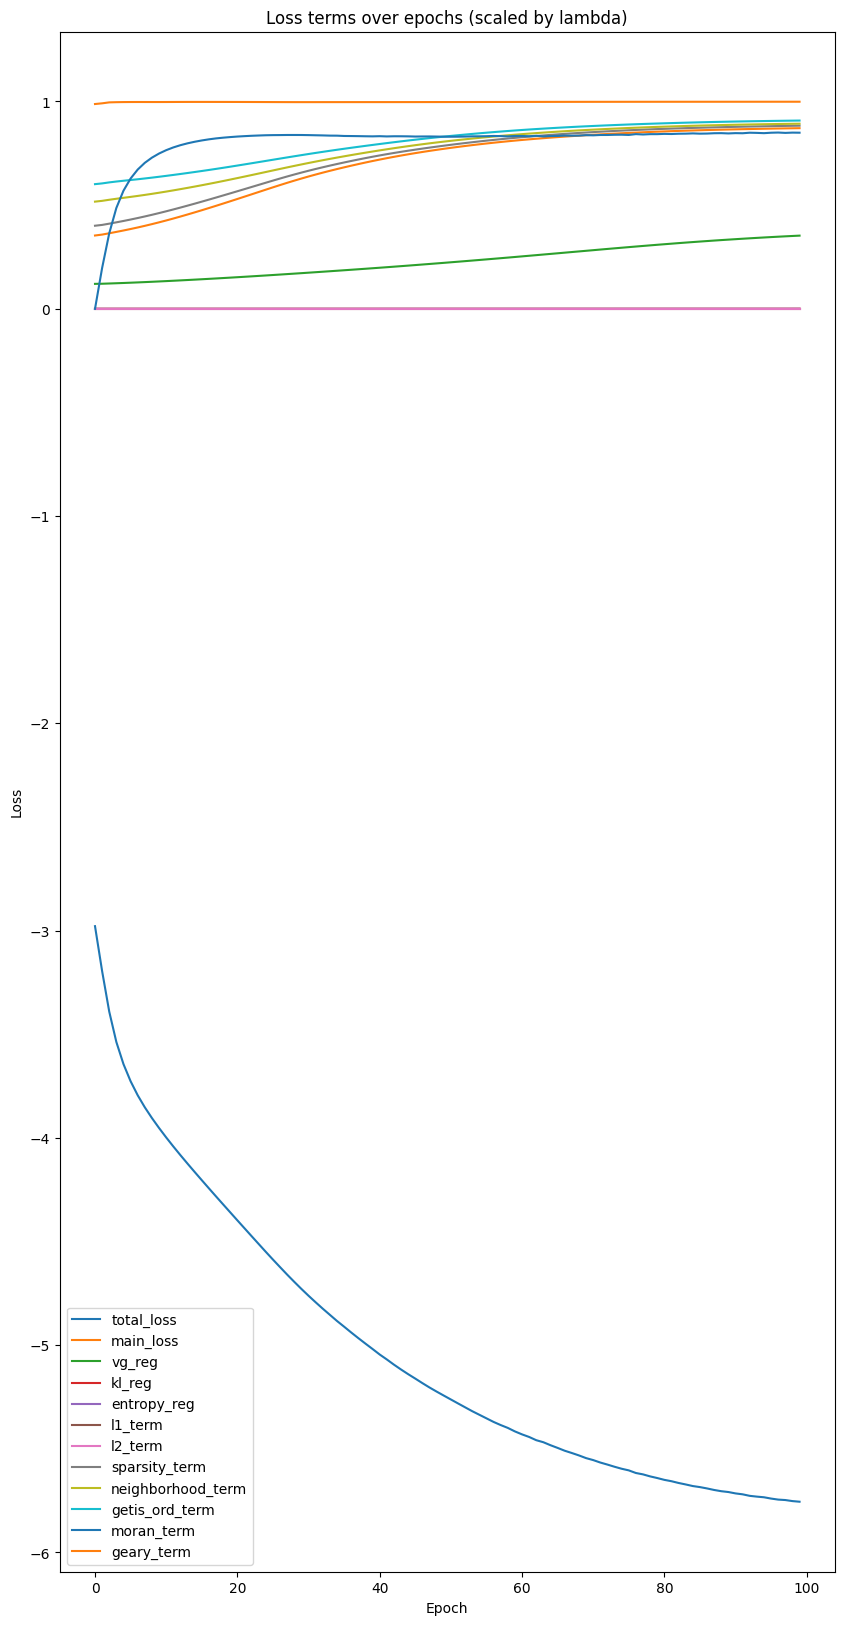

In [11]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True)

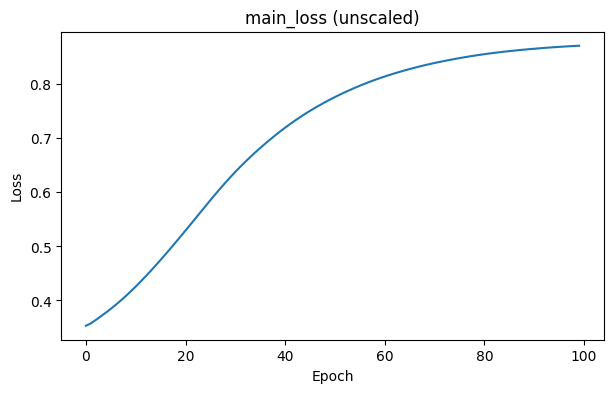

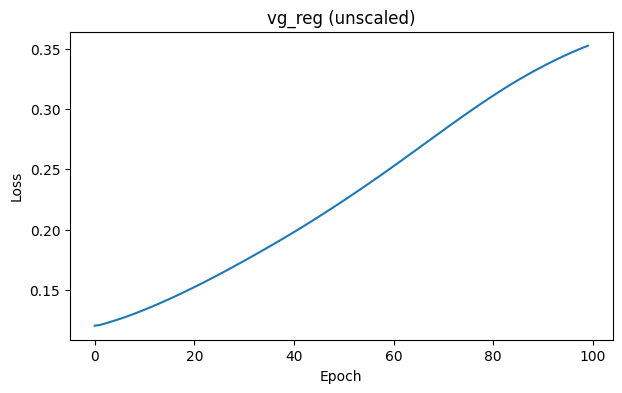

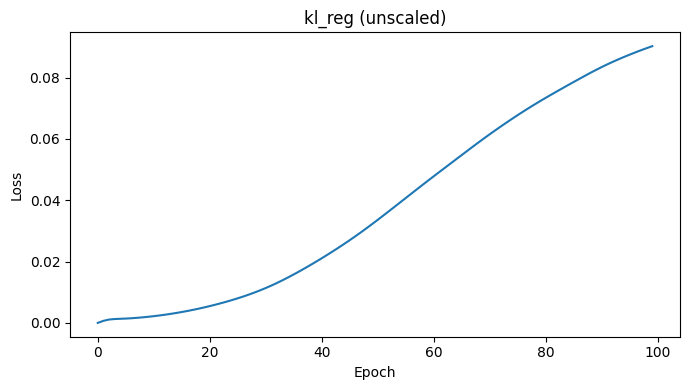

In [12]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

In [13]:
print("Final training score: ", ad_map.uns['training_history']['main_loss'][-1])

Final training score:  0.8711338639259338


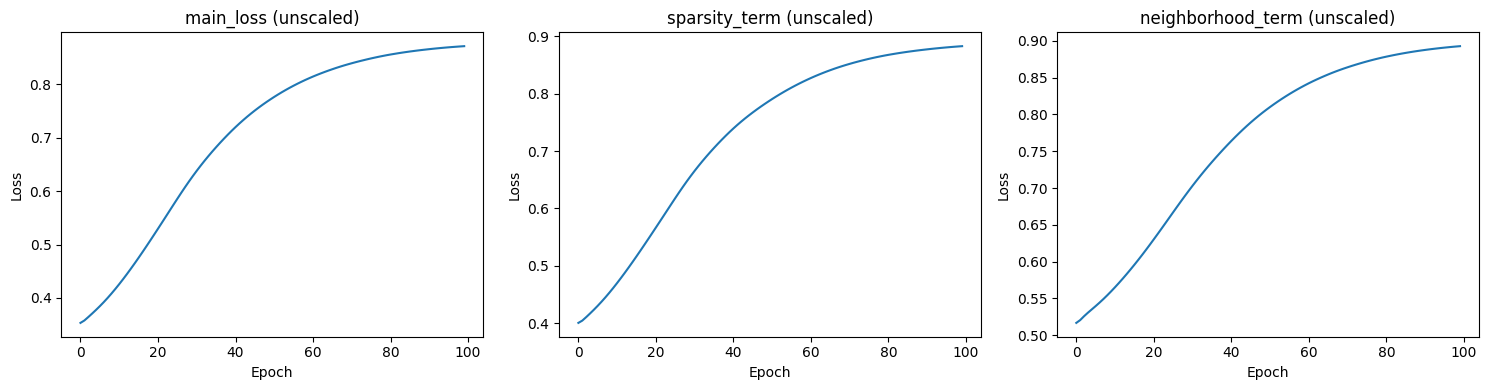

In [14]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

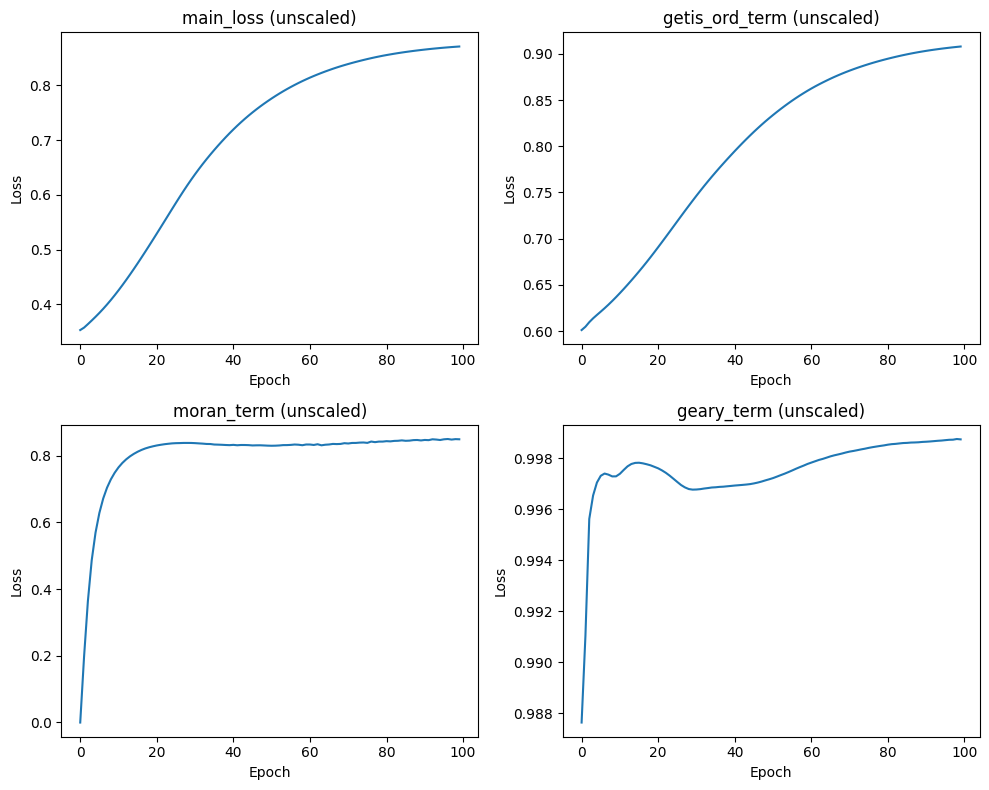

In [15]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

In [16]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

ValueError: Loss term 'ct_island_term' has empty history.

# Valdiate model

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


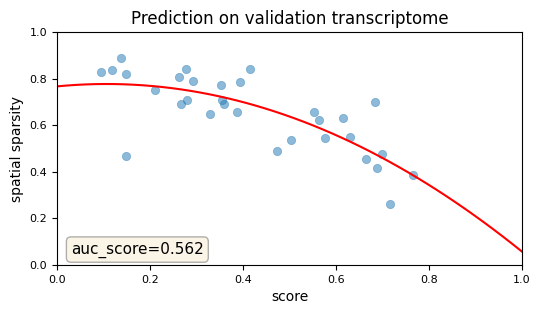

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.5620603561401367      │
│           val_JS            │     0.3455868065357208      │
│           val_PCC           │     0.2775976359844208      │
│          val_RMSE           │     1.1876634359359741      │
│          val_SSIM           │     0.2380727380514145      │
│         val_entropy         │     0.27680402994155884     │
│          val_score          │     0.4179322123527527      │
│ val_sparsity-weighted_score │     0.01563902199268341     │
└─────────────────────────────┴─────────────────────────────┘

In [17]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

# Sparsity

In [18]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 2000 × 27998
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    var: 'gene_ids', 'sparsity', 'is_training'
    uns: 'overlap_genes', 'training_genes'

In [19]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

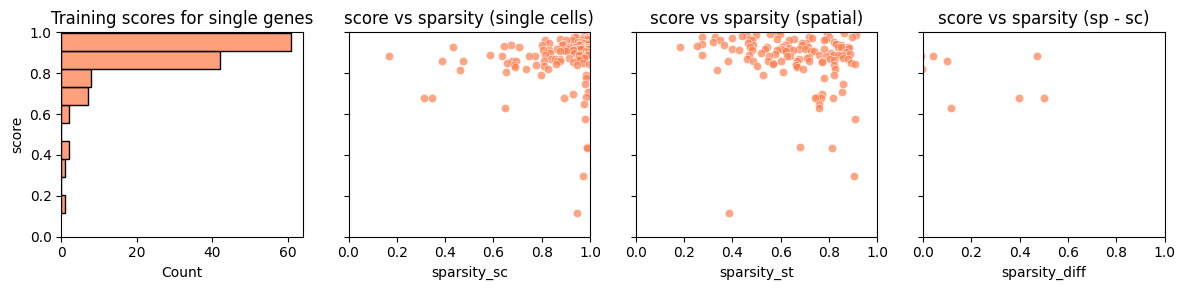

In [20]:
# Plot training scores panels
tgl.plot_training_scores(df)

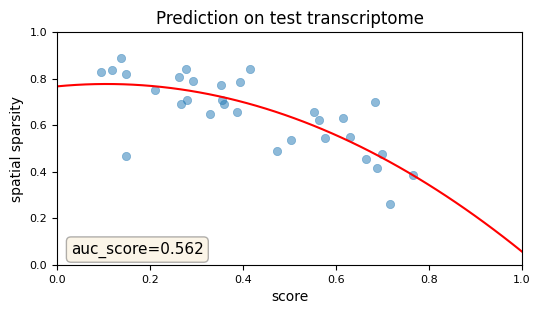

In [21]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

# Save

In [22]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset6', adata=ad_map, ext='h5ad')